# DNA Clustering and Classification

This notebook explores whether we can use mutational and copy number information to identify clusters of GLASS samples that overlap with Verhaak transcriptional subtype.

The actual consensus clustering is done by the NMFConsensus script from GenePattern here: https://github.com/genepattern/NMFConsensus/blob/develop/nmfconsensus.R, and the clustering parameters are as listed here: gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d96824cea2/jweiss/local_files/results/2024-07-22_GLASS-Verhaak-classifier/GLASS_sample_clustering.params.txt

The notebook also trains a classifier to predict membership in these DNA-based clusters and then applies this classifier to the ICB OncoPanel data.

This notebook generates the following figures:
* The clustering heatmap shown in Fig. 1c
* The sankey plot shown in Extended Data Fig. 3d

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from sklearn import metrics

ModuleNotFoundError: No module named 'sklearn'

In [2]:
np.random.seed(0)

In [ ]:
results_dir = '../results'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

# Load and preprocess GLASS data

## Clinical data

In [4]:
glass_surgeries_df = pd.read_csv('../data/glass_clinical_surgeries_table.tsv', sep = '\t')

In [5]:
glass_surgeries_df[(glass_surgeries_df["sample_barcode"].notnull()) & (glass_surgeries_df["idh_status"] != "IDHmut") & (glass_surgeries_df["histology"].str.match("Glioblastoma|Gliosarcoma").fillna(False).astype(bool))]#["case_barcode"].nunique()

/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_5044/2887213321.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  glass_surgeries_df[(glass_surgeries_df["sample_barcode"].notnull()) & (glass_surgeries_df["idh_status"] != "IDHmut") & (glass_surgeries_df["histology"].str.match("Glioblastoma|Gliosarcoma").fillna(False).astype(bool))]#["case_barcode"].nunique()


,case_barcode,surgery_number,sample_barcode,surgical_interval_mo,histology,grade,idh_status,codel_status,who_classification,mgmt_methylation,...,treatment_radiotherapy,treatment_radiation_dose_gy,treatment_radiation_fractions,treatment_radiation_other,treatment_chemotherapy_other,treatment_chemotherapy_other_cycles,comments,idh_codel_subtype,treatment_alkylating_agent,mgmt_methylation_method
1,GLSS-LU-00C4,1,GLSS-LU-00C4-TP,0.0,Glioblastoma,IV,IDHwt,noncodel,"Glioblastoma, IDH-wildtype",M,...,1,NaN,NaN,NaN,NaN,NaN,NaN,IDHwt,1,array
2,GLSS-LU-00C7,2,GLSS-LU-00C7-R1,17.0,Glioblastoma,IV,IDHwt,noncodel,"Glioblastoma, IDH-wildtype",U,...,0,NaN,NaN,NaN,NaN,NaN,NaN,IDHwt,NaN,array
3,GLSS-LU-00C7,1,GLSS-LU-00C7-TP,0.0,Glioblastoma,IV,IDHwt,noncodel,"Glioblastoma, IDH-wildtype",U,...,1,NaN,NaN,NaN,NaN,NaN,NaN,IDHwt,1,array
4,GLSS-LU-0B13,2,GLSS-LU-0B13-R1,14.0,Glioblastoma,IV,IDHwt,noncodel,"Glioblastoma, IDH-wildtype",M,...,0,NaN,NaN,NaN,NaN,NaN,NaN,IDHwt,NaN,array
5,GLSS-LU-0B13,1,GLSS-LU-0B13-TP,0.0,Glioblastoma,IV,IDHwt,noncodel,"Glioblastoma, IDH-wildtype",M,...,1,NaN,NaN,NaN,NaN,NaN,NaN,IDHwt,1,array
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,GLSS-HF-887A,3,GLSS-HF-887A-R1,8.0,Glioblastoma,IV,NaN,NaN,NaN,NaN,...,TRUE,32.0,NaN,NaN,CPT-11; Bevacizumab/Avastin,NaN,Tumor was highly necrotic,NaN,FALSE,NaN
977,GLSS-HF-891E,2,GLSS-HF-891E-R1,39.0,Glioblastoma,IV,NaN,NaN,NaN,NaN,...,FALSE,NaN,NaN,NaN,Procarbazine Hydrochloride; Vincristine Sulfat...,NaN,NaN,NaN,TRUE,NaN
978,GLSS-HF-891E,3,GLSS-HF-891E-R2,41.0,Glioblastoma,IV,NaN,NaN,NaN,NaN,...,FALSE,NaN,NaN,NaN,Carmustine; Tamoxifen,NaN,Carmustine as Gliadel wafer,NaN,TRUE,NaN
984,GLSS-HF-D48E,2,GLSS-HF-D48E-R1,36.0,Glioblastoma,IV,NaN,noncodel,NaN,U,...,FALSE,NaN,NaN,NaN,Bevacizumab/Avastin; CPT-11; Carboplatin; Etop...,NaN,NaN,NaN,TRUE,PCR


In [6]:
glass_surgeries_df = glass_surgeries_df[~glass_surgeries_df['sample_barcode'].isnull()]
glass_samples_df = glass_surgeries_df.set_index('sample_barcode')
print(glass_samples_df.shape)

(828, 29)


### Discard samples with non-GBM histology

In [7]:
glass_samples_df = glass_samples_df.loc[glass_samples_df['histology'].str.match("Glioblastoma|Gliosarcoma").fillna(False).astype(bool), :]
print(glass_samples_df.shape)

(557, 29)


/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_5044/3198457000.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  glass_samples_df = glass_samples_df.loc[glass_samples_df['histology'].str.match("Glioblastoma|Gliosarcoma").fillna(False).astype(bool), :]


### Discard samples with IDH-mut status

In [8]:
glass_samples_df = glass_samples_df.loc[glass_samples_df['idh_status'] != 'IDHmut']
print(glass_samples_df.shape)

(478, 29)


## WES

### Mutations

In [9]:
glass_variants_passgeno_df = pd.read_csv('../../../data/glass/variants_passgeno.csv', sep = ',', low_memory = False)
glass_variants_anno_df = pd.read_csv('../../../data/glass/variants_anno.csv', sep = ',', low_memory = False)
oncopanel_genes = pd.read_csv(os.path.join('../data/oncopanel_exonic_v123.txt'), sep = '\t')

In [10]:
# Create and save "sample" column
glass_variants_passgeno_df["sample"] = glass_variants_passgeno_df["aliquot_barcode"].str[:15]
wes_mut_samples = set(glass_variants_passgeno_df["sample"])

# Keep only the variants detected by single-sample MuTect2
glass_variants_passgeno_df = glass_variants_passgeno_df[glass_variants_passgeno_df["ssm2_pass_call"] == "t"]

# Keep only variants above the VAF threshold (0.1)
VAF_THRESHOLD = 0.1
glass_variants_passgeno_df = glass_variants_passgeno_df[glass_variants_passgeno_df['af'] >= VAF_THRESHOLD]

Join the variant annotations

In [11]:
def append_variant_id(df, colnames=["chrom","start","end","alt"]):
    df["variant_id"] = df[colnames[0]].astype(str)
    for c in colnames[1:]:
        df["variant_id"] = df["variant_id"] + ":" + df[c].astype(str)

def chrom_float_to_int(chrom_float):
    if np.isnan(chrom_float):
        return -1
    else:
        return int(chrom_float)

In [12]:
append_variant_id(glass_variants_passgeno_df)
append_variant_id(glass_variants_anno_df)

In [13]:
glass_variants_anno_df.set_index("variant_id", inplace=True)

In [14]:
kept_passgeno_cols = ["sample", "variant_id"] 
kept_anno_cols = ["chrom", "start", "ref", "alt", "gene_symbol", "variant_classification", "variant_type", "protein_change"]

glass_variants_df = glass_variants_passgeno_df[kept_passgeno_cols].join(glass_variants_anno_df[kept_anno_cols], on="variant_id", how="left")
print(glass_variants_df.shape)
glass_variants_df.head()

(3014019, 10)


,sample,variant_id,chrom,start,ref,alt,gene_symbol,variant_classification,variant_type,protein_change
583,GLSS-19-0266-R1,1:168513274:168513274:G,1.0,168513274.0,A,G,XCL2,FIVE_PRIME_FLANK,SNP,NaN
584,GLSS-19-0266-R1,1:168545864:168545864:G,1.0,168545864.0,A,G,XCL1,FIVE_PRIME_UTR,SNP,NaN
593,GLSS-19-0266-R1,1:197398786:197398786:A,1.0,197398786.0,G,A,CRB1,INTRON,SNP,NaN
598,GLSS-19-0266-R1,1:211652463:211652463:C,1.0,211652463.0,G,C,RD3,MISSENSE,SNP,p.T168S
601,GLSS-19-0266-R1,1:229771597:229771597:T,1.0,229771597.0,A,T,URB2,NONSENSE,SNP,p.K413*


Reorder/filter the columns to a more standard format.

Keep only genes with exons covered by all versions (v1, v2, v3) of OncoPanel.

Keep only variants on valid chromosomes (1-X).

Make sure variant positions are stored as integers.

Remove duplicate rows (not sure why these exist).

In [15]:
kept_glass_cols = ["sample", "chrom", "start", "ref", "alt", "gene_symbol", "variant_classification", "variant_type", "protein_change"]
glass_variants_df = glass_variants_df.loc[:, kept_glass_cols]

glass_variants_df = glass_variants_df[glass_variants_df['gene_symbol'].isin(oncopanel_genes['Gene'])]

glass_variants_df["chrom"] = glass_variants_df["chrom"].map(chrom_float_to_int).astype(int)
glass_variants_df = glass_variants_df[glass_variants_df["chrom"] > 0] # Missing chromosome labels were mapped to -1
glass_variants_df["chrom"] = np.where(glass_variants_df["chrom"] == 23, "X", glass_variants_df["chrom"])
glass_variants_df["start"] = glass_variants_df["start"].astype(int)

glass_variants_df = glass_variants_df.drop_duplicates()
print(glass_variants_df.shape)
glass_variants_df.head()

(29772, 9)


,sample,chrom,start,ref,alt,gene_symbol,variant_classification,variant_type,protein_change
687,GLSS-19-0266-R1,3,70005722,G,A,MITF,INTRON,SNP,NaN
970,GLSS-19-0266-R1,13,28913225,T,G,FLT1,INTRON,SNP,NaN
1160,GLSS-19-0266-R1,X,123220608,C,T,STAG2,NONSENSE,SNP,p.Q1089*
1267,GLSS-19-0266-TP,3,69990330,G,T,MITF,INTRON,SNP,NaN
1422,GLSS-19-0266-TP,7,140481402,C,G,BRAF,MISSENSE,SNP,p.G469A


Keep only non-synonymous variants

In [16]:
glass_variants_df['variant_classification'].value_counts()

variant_classification
INTRON                     23579
MISSENSE                    2521
FIVE_PRIME_FLANK            1102
SILENT                       799
THREE_PRIME_UTR              792
SPLICE_SITE                  253
FRAME_SHIFT_DEL              230
NONSENSE                     213
FIVE_PRIME_UTR               180
FRAME_SHIFT_INS               49
IN_FRAME_DEL                  40
IN_FRAME_INS                   4
START_CODON_SNP                3
DE_NOVO_START_IN_FRAME         3
DE_NOVO_START_OUT_FRAME        3
NONSTOP                        1
Name: count, dtype: int64

In [17]:
nonsyn_classifications = ['MISSENSE',
                          'SPLICE_SITE',
                          'FRAME_SHIFT_DEL',
                          'NONSENSE',
                          'FRAME_SHIFT_INS',
                          'IN_FRAME_DEL',
                          'IN_FRAME_INS',
                          'START_CODON_SNP',
                          'DE_NOVO_START_IN_FRAME',
                          'DE_NOVO_START_OUT_FRAME',
                          'NONSTOP']

glass_variants_df = glass_variants_df[glass_variants_df['variant_classification'].isin(nonsyn_classifications)]
glass_variants_df['variant_classification'].value_counts()

variant_classification
MISSENSE                   2521
SPLICE_SITE                 253
FRAME_SHIFT_DEL             230
NONSENSE                    213
FRAME_SHIFT_INS              49
IN_FRAME_DEL                 40
IN_FRAME_INS                  4
START_CODON_SNP               3
DE_NOVO_START_IN_FRAME        3
DE_NOVO_START_OUT_FRAME       3
NONSTOP                       1
Name: count, dtype: int64

### CNVs

In [18]:
glass_cnvs_df = pd.read_csv('../../../data/glass/cnvs.csv.gz')

In [19]:
# Create and save "sample" column
glass_cnvs_df["sample"] = glass_cnvs_df["aliquot_barcode"].str[:15]
wes_cnv_samples = set(glass_cnvs_df["sample"])

# Keep only CNVs (not copy-neutral segments)
glass_cnvs_df = glass_cnvs_df[glass_cnvs_df['hlvl_call'] != 0]

# Keep only genes with exons covered by all versions (v1, v2, v3) of OncoPanel.
glass_cnvs_df = glass_cnvs_df[glass_cnvs_df["gene_symbol"].isin(oncopanel_genes["Gene"])]

# Simplify CNV calls to just amp or del
glass_cnvs_df['cnv'] = glass_cnvs_df['hlvl_call'].map({2: 'amp', 1: 'amp', -1: 'del', -2: 'del'})

# Scoring
glass_cnvs_df['hlvl_call_abs'] = np.abs(glass_cnvs_df['hlvl_call'])

# Deduplicate, keeping strongest event
glass_cnvs_df.sort_values('hlvl_call_abs', inplace = True)
glass_cnvs_df = glass_cnvs_df.drop_duplicates(['sample', 'gene_symbol', 'cnv'], keep = 'first')

print(glass_cnvs_df.shape)
glass_cnvs_df.head()

(35563, 7)


,aliquot_barcode,gene_symbol,hlvl_call,wcr,sample,cnv,hlvl_call_abs
2228044,GLSS-AT-GP01-TP-02D-WXS-DPVLWZ,PDCD1LG2,-1,0.807710,GLSS-AT-GP01-TP,del,1
29156480,GLSS-MD-0044-R1-01D-WGS-VG0QP6,ABL1,1,1.141363,GLSS-MD-0044-R1,amp,1
29156491,GLSS-MD-0044-R1-01D-WGS-VG0QP6,EP300,1,1.100724,GLSS-MD-0044-R1,amp,1
29156625,GLSS-MD-0044-R1-01D-WGS-VG0QP6,MCL1,1,1.145647,GLSS-MD-0044-R1,amp,1
29156707,GLSS-MD-0044-R1-01D-WGS-VG0QP6,CREBBP,1,1.109192,GLSS-MD-0044-R1,amp,1


### Intersect sample lists

In [20]:
glass_samples_df.shape

(478, 29)

In [21]:
sample_intersection = (set(glass_samples_df.index).\
    intersection(wes_mut_samples).\
    intersection(wes_cnv_samples))

len(sample_intersection)

389

### Subset dataframes to these samples

In [22]:
variants_subset = glass_variants_df[glass_variants_df['sample'].isin(sample_intersection)]

cnvs_subset = glass_cnvs_df[glass_cnvs_df['sample'].isin(sample_intersection)]

print(variants_subset['sample'].nunique(),
      cnvs_subset['sample'].nunique())

330 361


In [23]:
def plot_variant_median_rates(variant_df, pt_col="sample", variant_col="hlvl_call"):
    counts = variant_df[variant_col].value_counts()
    per_pt_median_rates = variant_df.groupby([variant_col, pt_col]).size().reset_index().pivot_table(index=pt_col, columns=variant_col, fill_value=0.0).droplevel(0,axis=1).median()
    plt.bar(per_pt_median_rates.index, per_pt_median_rates.values)

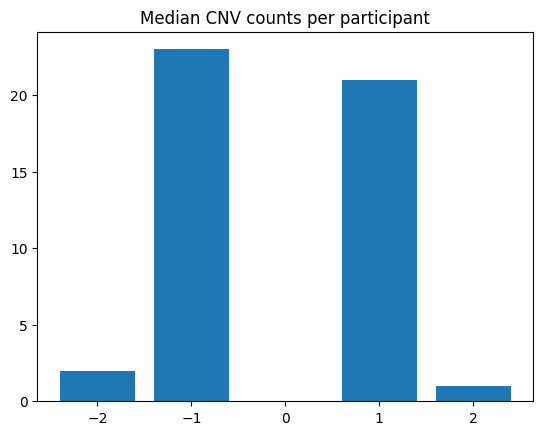

In [24]:
plot_variant_median_rates(cnvs_subset, pt_col="sample", variant_col="hlvl_call")
plt.title("Median CNV counts per participant")
plt.show()

### Create a combined mutation + CNV + subtype matrix

#### Mutations

In [25]:
variants_subset['gene_mut'] = variants_subset['gene_symbol'] + '_mut'
variants_matrix = variants_subset.pivot_table(index = 'sample', columns = 'gene_mut', aggfunc = 'size', fill_value = 0)

# Scoring: point mutations = 2
variants_matrix = variants_matrix * 2

variants_matrix.head()

/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_5044/389233590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants_subset['gene_mut'] = variants_subset['gene_symbol'] + '_mut'


gene_mut,ABL1_mut,AKT1_mut,AKT2_mut,AKT3_mut,ALK_mut,APC_mut,ARAF_mut,ARID1A_mut,ARID1B_mut,ARID2_mut,...,TSC1_mut,TSC2_mut,U2AF1_mut,WRN_mut,WT1_mut,XPA_mut,XPC_mut,XPO1_mut,ZNF217_mut,ZRSR2_mut
sample,,,,,,,,,,,,,,,,,,,,,
GLSS-19-0266-R1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GLSS-19-0266-TP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GLSS-19-0267-R1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GLSS-19-0267-TP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GLSS-19-0268-R1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### CNVs

In [26]:
cnvs_subset['gene_cnv'] = cnvs_subset['gene_symbol'] + '_' + cnvs_subset['cnv']
cnvs_matrix = cnvs_subset.pivot_table(index = 'sample', columns = 'gene_cnv', values = 'hlvl_call_abs', aggfunc = 'sum', fill_value = 0)

cnvs_matrix.head()

/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_5044/4001559487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnvs_subset['gene_cnv'] = cnvs_subset['gene_symbol'] + '_' + cnvs_subset['cnv']


gene_cnv,ABL1_amp,ABL1_del,AKT1_amp,AKT1_del,AKT2_amp,AKT2_del,AKT3_amp,AKT3_del,ALK_amp,ALK_del,...,XPA_amp,XPA_del,XPC_amp,XPC_del,XPO1_amp,XPO1_del,ZNF217_amp,ZNF217_del,ZRSR2_amp,ZRSR2_del
sample,,,,,,,,,,,,,,,,,,,,,
GLSS-19-0266-R1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
GLSS-19-0266-TP,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
GLSS-19-0267-R1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GLSS-19-0267-TP,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
GLSS-19-0268-TP,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0


#### Combined
Keep only variant types with 2 or more samples with an alteration

In [27]:
matrix = variants_matrix.join(cnvs_matrix, how = 'outer').fillna(0)
matrix = matrix.loc[:, matrix.astype(bool).astype(int).sum() >= 2].T

matrix.shape

(652, 365)

#### Write to file
Will need to convert this to .gct format manually

In [28]:
matrix.to_csv('../data/gene_sample_matrix.tsv', sep = '\t')

Clustering on GLASS DNA, apply those to our data, assess overlap with Verhaak subtype, use those in our regressions
- Richter's and DLBCL papers

## Run clustering with external script

As noted above:
> The actual consensus clustering is done by the NMFConsensus script from GenePattern here: https://github.com/genepattern/NMFConsensus/blob/develop/nmfconsensus.R, and the clustering parameters are as listed here: gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d96824cea2/jweiss/local_files/results/2024-07-22_GLASS-Verhaak-classifier/GLASS_sample_clustering.params.txt

The outputs appear to be located at `os.path.join(results_dir, 'GLASS_sample_clustering_v2.membership.gct')`.

# Assess clustering overlap with Verhaak subtype

## Load clustering results

In [29]:
memberships_68 = pd.read_csv("../data/GLASS_sample_clustering_revision.membership.gct", sep="\t", skiprows=2, index_col=0)
memberships_25 = pd.read_csv("../data/GLASS_sample_clustering_v2.membership.gct", sep="\t", skiprows=2, index_col=0)
memberships_68

,Description,membership,membership.1,membership.2
Name,,,,
GLSS.19.0266.R1,GLSS.19.0266.R1,1,1,1
GLSS.19.0266.TP,GLSS.19.0266.TP,2,2,2
GLSS.19.0267.R1,GLSS.19.0267.R1,1,1,1
GLSS.19.0267.TP,GLSS.19.0267.TP,3,3,3
GLSS.19.0268.R1,GLSS.19.0268.R1,4,3,3
...,...,...,...,...
TCGA.19.1389.R1,TCGA.19.1389.R1,3,3,3
TCGA.19.1389.TP,TCGA.19.1389.TP,6,5,4
TCGA.19.4065.R1,TCGA.19.4065.R1,1,5,4


In [30]:
memberships_25.rename(columns = {**{'membership': 'k = 2'}, **{f'membership.{i}': f'k = {i+2}' for i in range(1,8)}}, inplace = True)
memberships_68.rename(columns = {**{'membership': 'k = 6'}, **{f'membership.{i}': f'k = {i+6}' for i in range(1,8)}}, inplace = True)

memberships = memberships_25.join(memberships_68[[c for c in memberships_68.columns if c.startswith("k")]])

memberships.drop(columns = 'Description', inplace = True)
memberships.index = memberships.index.str.replace('.', '-')
memberships.head()

,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8
Name,,,,,,,
GLSS-19-0266-R1,1,1,1,1,1,1,1
GLSS-19-0266-TP,2,2,2,2,2,2,2
GLSS-19-0267-R1,1,1,1,1,1,1,1
GLSS-19-0267-TP,2,2,2,3,3,3,3
GLSS-19-0268-R1,2,3,3,4,4,3,3


## Load ssGSEA
(Verhaak subtype scores)

In [31]:
ssgsea = pd.read_csv(os.path.join("..", "data", 'glass_verhaak_scores.tsv'), sep = '\t', index_col = 1)
print(ssgsea.shape)
ssgsea.head()

(425, 8)


,case_barcode,VERHAAK_GLIOBLASTOMA_CLASSICAL,VERHAAK_GLIOBLASTOMA_MESENCHYMAL,VERHAAK_GLIOBLASTOMA_NEURAL,VERHAAK_GLIOBLASTOMA_PRONEURAL,Verhaak_subtype,surgery_number,surgical_interval_mo
sample_barcode,,,,,,,,
GLSS-19-0266-TP,GLSS-19-0266,4499.507042,3725.238591,1945.457473,2028.442349,VERHAAK_GLIOBLASTOMA_CLASSICAL,1,0.0
GLSS-19-0266-R1,GLSS-19-0266,3866.366259,3899.952531,3055.641397,1970.036575,VERHAAK_GLIOBLASTOMA_MESENCHYMAL,2,18.0
GLSS-19-0267-TP,GLSS-19-0267,3998.177157,2373.110794,2792.203914,3845.965090,VERHAAK_GLIOBLASTOMA_CLASSICAL,1,0.0
GLSS-19-0267-R1,GLSS-19-0267,3403.500159,1489.313078,4904.914629,3993.835349,VERHAAK_GLIOBLASTOMA_NEURAL,2,10.0
GLSS-19-0268-TP,GLSS-19-0268,4367.052085,2494.211618,813.639386,3709.522026,VERHAAK_GLIOBLASTOMA_CLASSICAL,1,0.0


Combine duplicated sample barcodes

In [32]:
ssgsea = ssgsea.groupby('sample_barcode').agg({'case_barcode': 'min',
                                               'VERHAAK_GLIOBLASTOMA_CLASSICAL' : 'mean',
                                               'VERHAAK_GLIOBLASTOMA_MESENCHYMAL': 'mean',
                                               'VERHAAK_GLIOBLASTOMA_PRONEURAL' : 'mean',
                                               'VERHAAK_GLIOBLASTOMA_NEURAL' : 'mean'})

ssgsea['Verhaak_subtype'] = ssgsea.iloc[:, 1:].idxmax(axis=1)
ssgsea.shape

(419, 6)

In [33]:
ssgsea['Verhaak_subtype'] = ssgsea['Verhaak_subtype'].apply(lambda x: x.split('_')[-1])
ssgsea.head()

,case_barcode,VERHAAK_GLIOBLASTOMA_CLASSICAL,VERHAAK_GLIOBLASTOMA_MESENCHYMAL,VERHAAK_GLIOBLASTOMA_PRONEURAL,VERHAAK_GLIOBLASTOMA_NEURAL,Verhaak_subtype
sample_barcode,,,,,,
GLSS-19-0266-R1,GLSS-19-0266,3866.366259,3899.952531,1970.036575,3055.641397,MESENCHYMAL
GLSS-19-0266-TP,GLSS-19-0266,4499.507042,3725.238591,2028.442349,1945.457473,CLASSICAL
GLSS-19-0267-R1,GLSS-19-0267,3403.500159,1489.313078,3993.835349,4904.914629,NEURAL
GLSS-19-0267-TP,GLSS-19-0267,3998.177157,2373.110794,3845.965090,2792.203914,CLASSICAL
GLSS-19-0268-R1,GLSS-19-0268,3271.104740,3855.965091,2225.823185,3986.308979,NEURAL


## Merge

In [34]:
overlap = ssgsea.join(memberships, how = 'inner').reset_index()
# overlap = overlap[overlap['Verhaak_subtype'].isin(['PRONEURAL', 'MESENCHYMAL'])]
print(len(memberships), len(ssgsea), len(overlap))
overlap['Verhaak_subtype'].value_counts()

365 419 246


Verhaak_subtype
CLASSICAL      80
MESENCHYMAL    79
NEURAL         58
PRONEURAL      29
Name: count, dtype: int64

## Calculate clustering overlap metrics
- Adjusted Rand Index
- Adjusted Mutual Information

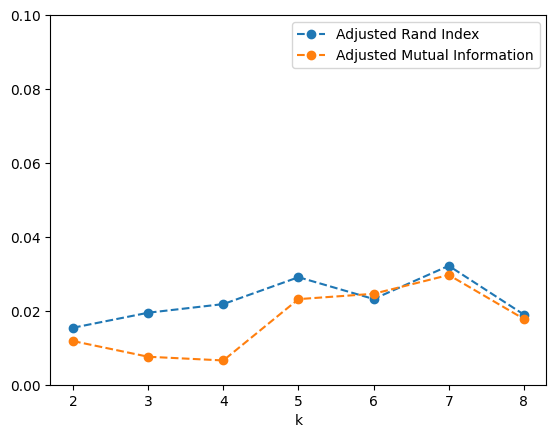

In [35]:
from sklearn import metrics

ARI = []
AMI = []
x = range(2, 9)
for k in x:
    ARI.append(metrics.adjusted_rand_score(overlap['Verhaak_subtype'], overlap[f'k = {k}']))
    AMI.append(metrics.adjusted_mutual_info_score(overlap[f'k = {k}'], overlap['Verhaak_subtype']))
    
plt.plot(x, ARI, 'o--', label = 'Adjusted Rand Index')
plt.plot(x, AMI, 'o--', label = 'Adjusted Mutual Information')
plt.ylim(0, 0.1)
plt.xticks(x)
plt.xlabel('k')
plt.legend()

## Plot overlap

In [36]:
counts = overlap.iloc[:,6:].value_counts().reset_index()
counts.columns = counts.columns[:-1].tolist() + ["count"]
counts.head()

,Verhaak_subtype,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,count
0,MESENCHYMAL,2,2,2,3,3,3,3,23
1,CLASSICAL,2,2,2,2,2,2,2,19
2,CLASSICAL,2,2,2,3,3,3,3,14
3,NEURAL,2,2,2,3,3,3,3,10
4,MESENCHYMAL,1,1,4,5,5,4,6,9


In [37]:
%reload_ext rpy2.ipython

Error importing in API mode: ImportError("dlopen(/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <3D361A20-57F1-3C9B-9D2B-6A0F70CF5F35> /Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable.

In [38]:
%%R -i counts -w 800 -h 600

require(ggalluvial)

cluster_alluvial <- ggplot(counts, aes(y = count,
                   axis1 = Verhaak_subtype,
                   axis2 = `k = 2`,
                   axis3 = `k = 3`,
                   axis4 = `k = 4`,
                   axis5 = `k = 5`,
                   axis6 = `k = 6`,
                   axis7 = `k = 7`,
                   axis8 = `k = 8`)) +
    geom_alluvium(aes(fill = Verhaak_subtype), width = 1/12) +
    geom_stratum(width = 1/6, fill = 'grey', color = 'black') +
    geom_label(stat = 'stratum', aes(label = after_stat(stratum))) +
    #scale_x_discrete(limits = c('Verhaak subtype', 'k = 2', 'k = 3', 'k = 4', 'k = 5'), expand = c(0.1, 0.05)) +
    scale_x_discrete(limits = c('Verhaak subtype', 'k = 2', 'k = 3', 'k = 4', 'k = 5', 'k = 6', 'k = 7', 'k = 8'), expand = c(0.1, 0.05)) +
    scale_fill_brewer(type = 'qual', palette = 'Dark2') +
    theme_classic(base_size = 16)

pdf("cluster_alluvial.pdf", width=15, height=12)
print(cluster_alluvial)
dev.off()

quartz_off_screen 
                2 


Loading required package: ggalluvial
Loading required package: ggplot2
Want to understand how all the pieces fit together? Read R for Data
Science: https://r4ds.hadley.nz/
In addition: Warning messages:
1: In to_lodes_form(data = data, axes = axis_ind, discern = params$discern) :
  Some strata appear at multiple axes.
2: In to_lodes_form(data = data, axes = axis_ind, discern = params$discern) :
  Some strata appear at multiple axes.
3: In to_lodes_form(data = data, axes = axis_ind, discern = params$discern) :
  Some strata appear at multiple axes.


In [39]:
%%R -i overlap -w 1200

library("tidyr")
require(ggpubr)

png(filename="cluster_ssgsea_scores.png", width=1200, height=600)

overlap_long <- overlap %>%
    pivot_longer(cols = starts_with('VERHAAK_GLIOBLASTOMA'), names_to = 'subtype', values_to = 'score')

#p2 <- ggboxplot(overlap_long, x = 'k = 3', y = 'score', facet.by = 'subtype') +
#    stat_compare_means()
    
p3 <- ggboxplot(overlap_long, x = 'k = 5', y = 'score', facet.by = 'subtype') +
    stat_compare_means()

p4 <- ggboxplot(overlap_long, x = 'k = 6', y = 'score', facet.by = 'subtype') +
    stat_compare_means()

ggarrange(p3, p4, ncol=2)

Loading required package: ggpubr


# Assess enrichment of variants within clusters

## Statistically (Fisher Exact test)

In [40]:
# Identify the clustering in which to test enrichments
k = 6

In [41]:
df = matrix.T.join(memberships)
df.to_csv('../results/variants_with_memberships_v2.tsv'), sep = '\t')
df.head(1)

,ABL1_mut,AKT1_mut,AKT2_mut,AKT3_mut,ALK_mut,APC_mut,ARAF_mut,ARID1A_mut,ARID1B_mut,ARID2_mut,...,ZNF217_del,ZRSR2_amp,ZRSR2_del,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8
sample,,,,,,,,,,,,,,,,,,,,,
GLSS-19-0266-R1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1,1,1,1,1,1


In [42]:
cluster_column = f'k = {k}'
results = []

for cluster in range(1, k + 1):
    for variant in df:
        if variant.startswith('k ='):
            continue

        # contingency table
        cluster_with_variant = len(df[(df[cluster_column] == cluster) & (df[variant] != 0)])
        cluster_without_variant = len(df[(df[cluster_column] == cluster) & (df[variant] == 0)])
        non_cluster_with_variant = len(df[(df[cluster_column] != cluster) & (df[variant] != 0)])
        non_cluster_without_variant = len(df[(df[cluster_column] != cluster) & (df[variant] == 0)])

        contingency_table = [
            [cluster_with_variant, cluster_without_variant],
            [non_cluster_with_variant, non_cluster_without_variant]
        ]

        # Fisher's exact test
        oddsratio, pvalue = stats.fisher_exact(contingency_table)

        results.append({
            'variant': variant,
            'odds_ratio': oddsratio,
            'p_value': pvalue,
            'cluster': cluster
        })

results_df = pd.DataFrame(results)
results_df['p_adj'] = multipletests(results_df['p_value'], alpha = 0.1, method = 'fdr_bh')[1]
results_df = results_df.sort_values('p_adj')

results_df.head()

,variant,odds_ratio,p_value,cluster,p_adj
1071,JAK3_amp,20.558824,1.768781e-27,2,6.919471e-24
890,BRD4_amp,19.644444,6.445656e-27,2,1.260770e-23
1101,MEF2B_amp,17.406495,2.649448e-25,2,3.454881e-22
946,CRTC1_amp,17.302222,3.689232e-25,2,3.608069e-22
1242,SMARCA4_amp,16.911765,9.990847e-25,2,7.816838e-22


Get chromosomes

In [43]:
bed = pd.read_csv('gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d96824cea2/cmesser/local_files/data/2023-08-15_gencode-bed/example_bed_gencode30.v30lift37.annotation.bed',
                  sep = '\t')
bed.head()

,gene_id,gene,chrom,start,end
0,ENSG00000223972.5_2,DDX11L1,chr1,11869,14409
1,ENSG00000227232.5_2,WASH7P,chr1,14404,29570
2,ENSG00000243485.5_5,MIR1302-2HG,chr1,29554,31109
3,ENSG00000237613.2_2,FAM138A,chr1,34554,36081
4,ENSG00000268020.3_4,OR4G4P,chr1,52473,53312


In [44]:
results_df['gene'] = results_df['variant'].str.split('_').str[0]
results_df['type'] = results_df['variant'].str.split('_').str[-1]
results_df = results_df.merge(bed[['gene', 'chrom']], on = 'gene', how = 'left')
results_df

,variant,odds_ratio,p_value,cluster,p_adj,gene,type,chrom
0,JAK3_amp,20.558824,1.768781e-27,2,6.919471e-24,JAK3,amp,chr19
1,BRD4_amp,19.644444,6.445656e-27,2,1.260770e-23,BRD4,amp,chr19
2,MEF2B_amp,17.406495,2.649448e-25,2,3.454881e-22,MEF2B,amp,chr19
3,CRTC1_amp,17.302222,3.689232e-25,2,3.608069e-22,CRTC1,amp,chr19
4,SMARCA4_amp,16.911765,9.990847e-25,2,7.816838e-22,SMARCA4,amp,chr19
...,...,...,...,...,...,...,...,...
3919,JAK3_amp,0.888344,1.000000e+00,4,1.000000e+00,JAK3,amp,chr19
3920,JAK2_del,0.888344,1.000000e+00,4,1.000000e+00,JAK2,del,chr9
3921,IGF1R_del,0.684091,1.000000e+00,4,1.000000e+00,IGF1R,del,chr15
3922,MECOM_del,0.000000,1.000000e+00,4,1.000000e+00,MECOM,del,chr3


In [45]:
hallmarks = results_df.groupby(['cluster', 'chrom', 'type']).agg({'odds_ratio': 'mean', 'p_adj': 'mean'}).reset_index().sort_values(['cluster', 'p_adj'])

for cluster in range(1, k + 1):
    print(hallmarks[hallmarks['cluster'] == cluster].head(10))

    cluster  chrom type  odds_ratio     p_adj
31        1  chr19  del   12.176314  0.000125
60        1   chr8  amp    9.526699  0.001363
63        1   chr9  amp   16.660055  0.005155
52        1   chr5  del    8.058133  0.006654
37        1  chr20  del   11.083325  0.006927
42        1  chr22  amp    7.183503  0.055846
54        1   chr6  amp   15.624538  0.130625
19        1  chr15  del    2.457044  0.140570
9         1  chr12  amp    4.636399  0.162452
58        1   chr7  del    6.214976  0.167237
     cluster  chrom type  odds_ratio         p_adj
101        2  chr19  amp   16.136399  4.180030e-19
107        2  chr20  amp    4.136348  1.801327e-06
87         2  chr14  del    0.115763  1.578115e-04
84         2  chr13  del    0.311947  6.983918e-03
90         2  chr15  del    0.133368  9.535650e-03
128        2   chr7  amp    4.096283  9.700154e-03
114        2  chr22  del    0.376857  1.254387e-02
111        2  chr21  del    0.000000  3.086038e-02
78         2  chr11  del    0.11789

## Visually (heatmap)
Sort according to genomic coordinate so we can better visualize clustering of CNVs

In [46]:
sig_variants = results_df[results_df['p_adj'] < 0.1][['variant']].drop_duplicates()
sig_variants['gene'] = sig_variants['variant'].str.split('_').str[0]

# symbol mismatches
sig_variants['gene_old'] = sig_variants['gene']
sig_variants.loc[sig_variants['gene'] == 'FAM46C', 'gene'] = 'TENT5C'
sig_variants.loc[sig_variants['gene'] == 'PARK2', 'gene'] = 'PRKN'

sig_variants = sig_variants.merge(bed, on = 'gene', how = 'left')

assert len(sig_variants[sig_variants['chrom'].isnull()]) == 0

sig_variants['chrom'] = sig_variants['chrom'].str.replace('chr', '').replace('X', '23').astype(int)

sig_variants.sort_values(['chrom', 'start'], inplace = True)

sig_variants

,variant,gene,gene_old,gene_id,chrom,start,end
67,MTOR_mut,MTOR,MTOR,ENSG00000198793.12_4,1,11166592,11322564
164,MTOR_amp,MTOR,MTOR,ENSG00000198793.12_4,1,11166592,11322564
248,MTOR_del,MTOR,MTOR,ENSG00000198793.12_4,1,11166592,11322564
149,SDHB_amp,SDHB,SDHB,ENSG00000117118.9_2,1,17345217,17380665
303,SDHB_del,SDHB,SDHB,ENSG00000117118.9_2,1,17345217,17380665
...,...,...,...,...,...,...,...
535,BCORL1_del,BCORL1,BCORL1,ENSG00000085185.15_5,23,129115083,129192058
438,GPC3_mut,GPC3,GPC3,ENSG00000147257.13_3,23,132669773,133119922
469,GPC3_amp,GPC3,GPC3,ENSG00000147257.13_3,23,132669773,133119922
351,PHF6_del,PHF6,PHF6,ENSG00000156531.16_3,23,133507283,133562821


In [47]:
print(
    sum(sig_variants['variant'].str.contains('_amp')),
    sum(sig_variants['variant'].str.contains('_del')),
    sum(sig_variants['variant'].str.contains('_mut')),
)

220 193 137


Combine amps and dels

In [48]:
matrix_sig = matrix.T.loc[:, sig_variants['variant']]
new_df = {}

for gene in sig_variants['gene_old']:
    if f'{gene}_mut' in matrix_sig:
        new_df[f'{gene}_mut'] = matrix_sig[f'{gene}_mut']
        
    if f'{gene}_amp' in matrix_sig and f'{gene}_del' in matrix_sig:
        new_df[f'{gene}_cnv'] = matrix_sig[f'{gene}_amp'] + (-1 * matrix_sig[f'{gene}_del'])
    elif f'{gene}_del' in matrix_sig:
        new_df[f'{gene}_cnv'] = -1 * matrix_sig[f'{gene}_del']
    elif f'{gene}_amp' in matrix_sig:
        new_df[f'{gene}_cnv'] = matrix_sig[f'{gene}_amp']

matrix_sig = pd.DataFrame.from_dict(new_df)
df_sig = matrix_sig.join(memberships)
df_sig.head()

,MTOR_mut,MTOR_cnv,SDHB_cnv,ID3_cnv,ARID1A_mut,ARID1A_cnv,MYCL_mut,MYCL_cnv,MPL_cnv,MUTYH_cnv,...,GPC3_mut,GPC3_cnv,PHF6_cnv,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8
sample,,,,,,,,,,,,,,,,,,,,,
GLSS-19-0266-R1,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1,1,1,1,1,1
GLSS-19-0266-TP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,2,2,2,2,2
GLSS-19-0267-R1,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1,1,1,1,1,1
GLSS-19-0267-TP,0.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,2,3,3,3,3
GLSS-19-0268-R1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,3,3,4,4,3,3


In [49]:
cnv_chrom_df = sig_variants[['gene_old', 'chrom']].drop_duplicates()
cnv_chrom_df['gene_cnv'] = cnv_chrom_df['gene_old'] + '_cnv'
cnv_chrom_df = cnv_chrom_df[cnv_chrom_df['gene_cnv'].isin(list(df_sig))]
cnv_chrom_df.drop(columns = 'gene_old', inplace = True)
cnv_chrom_df.set_index('gene_cnv', inplace = True)
cnv_chrom_df

,chrom
gene_cnv,
MTOR_cnv,1
SDHB_cnv,1
ID3_cnv,1
ARID1A_cnv,1
MYCL_cnv,1
...,...
ATRX_cnv,23
STAG2_cnv,23
BCORL1_cnv,23


In [50]:
sig_variants.head()

,variant,gene,gene_old,gene_id,chrom,start,end
67,MTOR_mut,MTOR,MTOR,ENSG00000198793.12_4,1,11166592,11322564
164,MTOR_amp,MTOR,MTOR,ENSG00000198793.12_4,1,11166592,11322564
248,MTOR_del,MTOR,MTOR,ENSG00000198793.12_4,1,11166592,11322564
149,SDHB_amp,SDHB,SDHB,ENSG00000117118.9_2,1,17345217,17380665
303,SDHB_del,SDHB,SDHB,ENSG00000117118.9_2,1,17345217,17380665


In [51]:
cnv_chrom_df["chrom"].dtype

dtype('int64')

In [52]:
%%R -i df_sig -i cnv_chrom_df -w 3000 -h 1200
library(ComplexHeatmap)
library(circlize)
library(RColorBrewer)

df_sig <- df_sig[order(df_sig$`k = 6`),]

muts <- as.matrix(df_sig[, grep('_mut', names(df_sig))])
cnvs <- as.matrix(df_sig[, grep('_cnv', names(df_sig))])

clusters <- df_sig[, grep('=', names(df_sig))]

cluster_colors <- brewer.pal(n = 8, name = 'Dark2')

chrom_colors <- rep(c(cluster_colors[6], cluster_colors[8]), length.out = 23)
chrom_colors <- setNames(chrom_colors, 1:23)

row_ha <- rowAnnotation(#Cluster_2 = clusters$`k = 2`,
                        #Cluster_3 = clusters$`k = 3`,
                        #Cluster_4 = clusters$`k = 4`,
                        Cluster_5 = clusters$`k = 5`,
                        Cluster_6 = clusters$`k = 6`,
                        col = list(#Cluster_2 = c(`1` = cluster_colors[1], `2` = cluster_colors[2]),
                                   #Cluster_3 = c(`1` = cluster_colors[1], `2` = cluster_colors[2], `3` = cluster_colors[3]),
                                   #Cluster_4 = c(`1` = cluster_colors[1], `2` = cluster_colors[2], `3` = cluster_colors[3], `4` = cluster_colors[4]),
                                   Cluster_5 = c(`1` = cluster_colors[1], `2` = cluster_colors[2], `3` = cluster_colors[3], `4` = cluster_colors[4], `5` = cluster_colors[5]),
                                   Cluster_6 = c(`1` = cluster_colors[1], `2` = cluster_colors[2], `3` = cluster_colors[3], `4` = cluster_colors[4], `5` = cluster_colors[5], `6` = cluster_colors[6])),
                        simple_anno_size = unit(2, 'cm'))

col_ha <- columnAnnotation(df = cnv_chrom_df,
                          simple_anno_size = unit(2, 'cm'),
                          col = list(chrom = chrom_colors))

heatmap_muts <- Heatmap(muts, name = 'SNV/indels',
                        col = colorRamp2(c(0, 2, 4), c('white', 'grey', 'black')),
                        cluster_rows = FALSE, cluster_columns = FALSE,
                        show_row_names = FALSE)

heatmap_cnvs <- Heatmap(cnvs, name = 'CNVs', right_annotation = row_ha, top_annotation = col_ha,
                        col = colorRamp2(c(-2, 0, 2), c('blue', 'white', 'red')),
                        cluster_rows = FALSE, cluster_columns = FALSE,
                        show_row_names = FALSE)

full_heatmap <- heatmap_muts + heatmap_cnvs
pdf("glass_heatmap.pdf", width=50, height=20)
draw(full_heatmap)
dev.off()

quartz_off_screen 
                2 


Loading required package: grid
ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))

circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and

# Assess prognostic value of clusters

Adjust for MGMT methylation status!

## Merge cluster assignments with OS

In [53]:
glass_cases_df = pd.read_csv('../../../data/2022-08-10_glass/clinical_cases_table.tsv', sep = '\t',
                            usecols = ['case_barcode', 'case_overall_survival_mo', 'case_vital_status'])
glass_cases_df.head()

,case_barcode,case_vital_status,case_overall_survival_mo
0,GLSS-DF-0002,dead,11.0
1,GLSS-DF-0003,dead,9.0
2,GLSS-HK-0001,dead,25.0
3,GLSS-MD-0006,dead,93.0
4,GLSS-MD-0002,dead,262.0


In [54]:
glass_samples_df['mgmt_methylation'].value_counts(dropna = False)

mgmt_methylation
NaN    272
U      128
M       78
Name: count, dtype: int64

In [55]:
memberships_with_os = memberships.\
    join(glass_samples_df[['case_barcode', 'surgical_interval_mo', 'mgmt_methylation']], how = 'left').\
    reset_index(names = 'sample_barcode').\
    merge(glass_cases_df, on = 'case_barcode', how = 'left').\
    replace({'dead': True, 'alive': False})

memberships_with_os = memberships_with_os[memberships_with_os['case_overall_survival_mo'].notnull() &
                                          memberships_with_os['surgical_interval_mo'].notnull() &
                                          memberships_with_os['mgmt_methylation'].notnull()]

memberships_with_os['os_harmonized'] = np.where(
    memberships_with_os['sample_barcode'].str.endswith('-TP'),
    memberships_with_os['case_overall_survival_mo'],
    memberships_with_os['case_overall_survival_mo'] - memberships_with_os['surgical_interval_mo'],
)

memberships_with_os['setting'] = np.where(
    memberships_with_os['sample_barcode'].str.endswith('-TP'),
    'Newly diagnosed',
    'Recurrent'
)

memberships_with_os['mgmt_methylation'] = np.where(
    memberships_with_os['mgmt_methylation'] == 'M', 1.0, 0.0
)

memberships_with_os

/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_5044/2411381081.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  replace({'dead': True, 'alive': False})


,sample_barcode,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,case_barcode,surgical_interval_mo,mgmt_methylation,case_vital_status,case_overall_survival_mo,os_harmonized,setting
1,GLSS-19-0266-TP,2,2,2,2,2,2,2,GLSS-19-0266,0.0,1.0,True,35.0,35.0,Newly diagnosed
3,GLSS-19-0267-TP,2,2,2,3,3,3,3,GLSS-19-0267,0.0,0.0,True,14.0,14.0,Newly diagnosed
11,GLSS-19-0271-TP,2,2,2,2,2,2,2,GLSS-19-0271,0.0,0.0,True,14.0,14.0,Newly diagnosed
27,GLSS-AT-00P1-TP,1,2,4,2,2,2,2,GLSS-AT-00P1,0.0,0.0,True,37.0,37.0,Newly diagnosed
33,GLSS-AT-00P4-TP,2,2,2,3,3,3,3,GLSS-AT-00P4,0.0,1.0,True,14.0,14.0,Newly diagnosed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,TCGA-19-1389-R1,2,2,2,3,3,3,3,TCGA-19-1389,3.0,0.0,True,5.0,2.0,Recurrent
361,TCGA-19-1389-TP,1,1,4,5,6,5,4,TCGA-19-1389,0.0,0.0,True,5.0,5.0,Newly diagnosed
362,TCGA-19-4065-R1,1,1,1,1,1,5,4,TCGA-19-4065,2.0,0.0,True,15.0,13.0,Recurrent
363,TCGA-19-4065-TP,1,1,4,5,1,5,4,TCGA-19-4065,0.0,0.0,True,15.0,15.0,Newly diagnosed


In [56]:
for clust in range(1, 1+8):
    memberships_with_os[f"cluster_{clust}"] = memberships_with_os["k = 6"].map(lambda x: x == clust).astype(int)

In [57]:
memberships_with_os

,sample_barcode,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,case_barcode,surgical_interval_mo,...,os_harmonized,setting,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
1,GLSS-19-0266-TP,2,2,2,2,2,2,2,GLSS-19-0266,0.0,...,35.0,Newly diagnosed,0,1,0,0,0,0,0,0
3,GLSS-19-0267-TP,2,2,2,3,3,3,3,GLSS-19-0267,0.0,...,14.0,Newly diagnosed,0,0,1,0,0,0,0,0
11,GLSS-19-0271-TP,2,2,2,2,2,2,2,GLSS-19-0271,0.0,...,14.0,Newly diagnosed,0,1,0,0,0,0,0,0
27,GLSS-AT-00P1-TP,1,2,4,2,2,2,2,GLSS-AT-00P1,0.0,...,37.0,Newly diagnosed,0,1,0,0,0,0,0,0
33,GLSS-AT-00P4-TP,2,2,2,3,3,3,3,GLSS-AT-00P4,0.0,...,14.0,Newly diagnosed,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,TCGA-19-1389-R1,2,2,2,3,3,3,3,TCGA-19-1389,3.0,...,2.0,Recurrent,0,0,1,0,0,0,0,0
361,TCGA-19-1389-TP,1,1,4,5,6,5,4,TCGA-19-1389,0.0,...,5.0,Newly diagnosed,0,0,0,0,0,1,0,0
362,TCGA-19-4065-R1,1,1,1,1,1,5,4,TCGA-19-4065,2.0,...,13.0,Recurrent,1,0,0,0,0,0,0,0
363,TCGA-19-4065-TP,1,1,4,5,1,5,4,TCGA-19-4065,0.0,...,15.0,Newly diagnosed,1,0,0,0,0,0,0,0


In [58]:
# Get participant-level cluster memberships;
# Just choose the modal value.
pt_memberships_with_os = memberships_with_os.groupby("case_barcode").agg(lambda x: x.value_counts().index[0]).reset_index()

## k = 5

In [59]:
%%R -i pt_memberships_with_os
library(tidyverse)
library(survival)

combined <- pt_memberships_with_os %>%
    mutate(across(starts_with('k = '), as.factor)) %>%
    rename(cluster = `k = 5`)

nd <- combined %>% filter(str_equal(setting, 'Newly diagnosed'))
rc <- combined %>% filter(str_equal(setting, 'Recurrent'))

print(dim(combined))
print(dim(nd))
print(dim(rc))

model_5_combined <- coxph(Surv(os_harmonized, case_vital_status) ~ setting + mgmt_methylation + cluster,
                          data = combined)
model_5_nd <- coxph(Surv(os_harmonized, case_vital_status) ~ mgmt_methylation + cluster,
                          data = nd)
model_5_rc <- coxph(Surv(os_harmonized, case_vital_status) ~ mgmt_methylation + cluster,
                          data = rc)

univariate_1 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_1,
                      data = pt_memberships_with_os)
univariate_2 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_2,
                      data = pt_memberships_with_os)
univariate_3 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_3,
                      data = pt_memberships_with_os)
univariate_4 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_4,
                      data = pt_memberships_with_os)
univariate_5 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_5,
                      data = pt_memberships_with_os)

print(summary(model_5_combined))
print(summary(model_5_nd))
print(summary(model_5_rc))

print(summary(univariate_1))
print(summary(univariate_2))
print(summary(univariate_3))
print(summary(univariate_4))
print(summary(univariate_5))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
[1] 105  23
[1] 41 23
[1] 64 23
Call:
coxph(formula = Surv(os_harmonized, case_vital_status) ~ setting + 
    mgmt_methylation + cluster, data = combined)

  n= 105, number of events= 103 

                    coef exp(coef) se(coef)      z Pr(>|z|)    
settingRecurrent  0.9563    2.6020   0.2237  4.275 1.91e-05 ***
mgmt_methylation -0.1061    0.8994   0.2218 -0.478   0.6325    
cluster2         -0.6115    0.5425   0.3137 -1.950   0.0512 .  
cluster3          0.1880    1.2068   0.3010  0.624   0.5324    
cluste

## k = 6

In [60]:
%%R -i pt_memberships_with_os
library(tidyverse)
library(survival)

combined <- pt_memberships_with_os %>%
    mutate(across(starts_with('k = '), as.factor)) %>%
    rename(cluster = `k = 6`)

nd <- combined %>% filter(str_equal(setting, 'Newly diagnosed'))
rc <- combined %>% filter(str_equal(setting, 'Recurrent'))

print(dim(combined))
print(dim(nd))
print(dim(rc))

model_6_combined <- coxph(Surv(os_harmonized, case_vital_status) ~ setting + mgmt_methylation + cluster,
                          data = combined)
model_6_nd <- coxph(Surv(os_harmonized, case_vital_status) ~ mgmt_methylation + cluster,
                          data = nd)
model_6_rc <- coxph(Surv(os_harmonized, case_vital_status) ~ mgmt_methylation + cluster,
                          data = rc)

univariate_1 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_1,
                      data = pt_memberships_with_os)
univariate_2 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_2,
                      data = pt_memberships_with_os)
univariate_3 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_3,
                      data = pt_memberships_with_os)
univariate_4 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_4,
                      data = pt_memberships_with_os)
univariate_5 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_5,
                      data = pt_memberships_with_os)
univariate_6 <- coxph(Surv(os_harmonized, case_vital_status) ~ cluster_6,
                      data = pt_memberships_with_os)

print(summary(model_6_combined))
print(summary(model_6_nd))
print(summary(model_6_rc))

print(summary(univariate_1))
print(summary(univariate_2))
print(summary(univariate_3))
print(summary(univariate_4))
print(summary(univariate_5))
print(summary(univariate_6))

[1] 105  23
[1] 41 23
[1] 64 23
Call:
coxph(formula = Surv(os_harmonized, case_vital_status) ~ setting + 
    mgmt_methylation + cluster, data = combined)

  n= 105, number of events= 103 

                     coef exp(coef) se(coef)      z Pr(>|z|)    
settingRecurrent  0.92710   2.52716  0.22275  4.162 3.15e-05 ***
mgmt_methylation -0.03383   0.96673  0.23593 -0.143   0.8860    
cluster2         -0.84931   0.42771  0.33879 -2.507   0.0122 *  
cluster3          0.01776   1.01792  0.29073  0.061   0.9513    
cluster4         -0.39478   0.67383  0.51785 -0.762   0.4459    
cluster5         -0.45068   0.63720  0.39982 -1.127   0.2597    
cluster6         -0.51068   0.60009  0.37985 -1.344   0.1788    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                 exp(coef) exp(-coef) lower .95 upper .95
settingRecurrent    2.5272     0.3957    1.6331    3.9106
mgmt_methylation    0.9667     1.0344    0.6088    1.5351
cluster2            0.4277     2.3380    0.2202 

# Find a performant classifier
Borrowing some code from David's train_classifier.py

In [61]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold

In [62]:
X = matrix_sig
y = df_sig['k = 6']

counts = y.value_counts()
dist = counts / counts.sum()

print('Class distribution')
print(counts)
print(dist)

Class distribution
k = 6
3    120
2     86
6     49
1     47
5     39
4     24
Name: count, dtype: int64
k = 6
3    0.328767
2    0.235616
6    0.134247
1    0.128767
5    0.106849
4    0.065753
Name: count, dtype: float64


In [63]:
knn = KNeighborsClassifier()
cent = NearestCentroid()
rf = RandomForestClassifier(n_estimators = 1000)
lr = LogisticRegression(solver = 'saga', max_iter = 20000)
sgd = SGDClassifier(max_iter = 20000)

n_folds = 5

p_grid = [
    {
        'classifier': [knn],
        'classifier__n_neighbors': [1,2,3,4,5,6,7,8],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [cent],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    {
        'classifier': [rf],
        'classifier__criterion': ['gini', 'entropy', 'log_loss']
    },
    {
        'classifier': [lr],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [1e-1, 1, 10, 20]
    },
    {
        'classifier': [sgd],
#        'classifier__loss': ['hinge', 'log_loss'],
        'classifier__loss': ['log_loss'],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
    }
]

pipeline = Pipeline([('classifier', rf)])

gscv = GridSearchCV(pipeline, p_grid, scoring = 'accuracy', n_jobs = 8, cv = n_folds, verbose = 1)

scores = cross_validate(gscv, X, y, cv = n_folds)

best_model = gscv.fit(X, y).best_estimator_.named_steps['classifier']

Fitting 5 folds for each of 43 candidates, totalling 215 fits


/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at le

Fitting 5 folds for each of 43 candidates, totalling 215 fits


/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at le

Fitting 5 folds for each of 43 candidates, totalling 215 fits


/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at le

Fitting 5 folds for each of 43 candidates, totalling 215 fits


/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at le

Fitting 5 folds for each of 43 candidates, totalling 215 fits


/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at le

Fitting 5 folds for each of 43 candidates, totalling 215 fits


/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(
/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at le

In [64]:
gscv.best_params_

{'classifier': SGDClassifier(max_iter=20000),
 'classifier__alpha': 1e-05,
 'classifier__loss': 'log_loss',
 'classifier__penalty': 'l1'}

In [65]:
best_model

,loss,'log_loss'
,penalty,'l1'
,alpha,1e-05
,l1_ratio,0.15
,fit_intercept,True
,max_iter,20000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [66]:
cross_val_score(best_model, X, y, cv = 5).mean()

np.float64(0.7479452054794521)

In [67]:
best_model.coef_

array([[   2.66465631,  125.01816781,   30.44080466, ...,    0.        ,
           1.56365377,   51.04194943],
       [  50.68805105,   45.89977385,   78.25022871, ...,    0.        ,
         -68.63804931,  -67.47923114],
       [-252.86212567, -127.96714129,   -9.27857909, ...,    0.        ,
         -34.4760229 ,   78.70852831],
       [ 118.89026094,   28.68021432,   37.69301906, ...,   34.18236582,
          -4.38676664,   11.82497289],
       [ -34.02555558,   14.73969189,  -42.84779585, ...,    0.        ,
          67.21639477,   -0.77244131],
       [ -85.59074891,  112.55975052,   48.72187545, ...,    0.        ,
           1.98041582,   31.11846206]], shape=(6, 373))

In [68]:
X

,MTOR_mut,MTOR_cnv,SDHB_cnv,ID3_cnv,ARID1A_mut,ARID1A_cnv,MYCL_mut,MYCL_cnv,MPL_cnv,MUTYH_cnv,...,AR_mut,AR_cnv,ATRX_mut,ATRX_cnv,STAG2_cnv,BCORL1_mut,BCORL1_cnv,GPC3_mut,GPC3_cnv,PHF6_cnv
sample,,,,,,,,,,,,,,,,,,,,,
GLSS-19-0266-R1,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
GLSS-19-0266-TP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLSS-19-0267-R1,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
GLSS-19-0267-TP,0.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLSS-19-0268-R1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-19-1389-R1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.0,2.0,0.0,-1.0,0.0,0.0,0.0
TCGA-19-1389-TP,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.0,...,0.0,-1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,1.0
TCGA-19-4065-R1,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [69]:
best_model.fit(X, y)

coeffs = best_model.coef_
coeffs = pd.DataFrame(coeffs).T
coeffs.index = [c for c in df_sig.columns if not c.startswith("k =")]
coeffs.sort_values(1)

,0,1,2,3,4,5
AXL_mut,0.000000,-203.397854,0.000000,66.505159,0.000000,-87.524084
STAT6_cnv,37.061223,-198.797572,36.491025,34.366344,-33.664452,28.281377
BCORL1_cnv,-45.754198,-193.789628,1.580640,-80.178330,-9.704101,41.343732
BCL6_cnv,10.911213,-193.195327,-74.271486,-33.733633,-27.688955,43.611151
NFE2L2_cnv,0.000000,-176.105316,-85.139526,-16.750548,33.273700,48.421688
...,...,...,...,...,...,...
SH2B3_cnv,93.051086,159.752569,-34.743604,32.881120,-83.868684,-74.663942
PTPN11_cnv,64.317704,164.228864,64.623063,49.036652,-66.369075,-41.998549
TP53_cnv,-23.485257,165.087856,-125.997539,52.638229,44.124946,-16.600590
B2M_cnv,11.653804,190.906469,-84.013094,0.000000,-19.975612,39.904044


# Does PCA tell us anything?

[0.10331687 0.08294037 0.05099463 0.04129514 0.0346887 ]


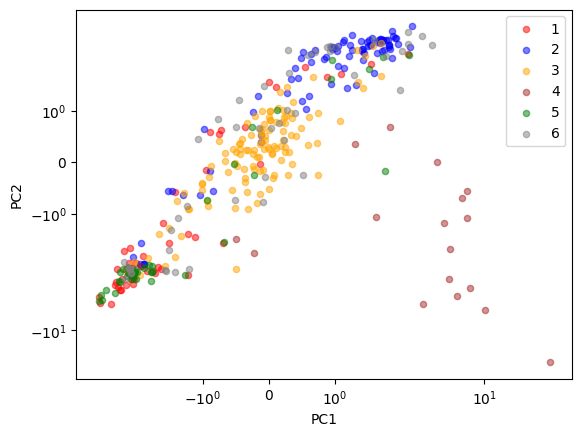

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5)
X_r = pca.fit_transform(X)
# X_icb_r = pca.transform(op_matrix_sig)

print(pca.explained_variance_ratio_)

colors = ['red', 'blue', 'orange', 'brown', 'green', 'gray']
# plt.scatter(X_icb_r[:,0], X_icb_r[:,1], s = 40, color = 'gray', alpha = 0.8, lw = 1, label = 'ICB')

for i, color in enumerate(colors):
    plt.scatter(X_r[y == i + 1, 0], X_r[y == i + 1, 1], s = 20, color = color, alpha = 0.5, lw = 1, label = i + 1)
plt.legend(loc = 'best')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xscale('symlog')
plt.yscale('symlog')

In [71]:
pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=list(X)).sort_values('PC2').head(10)

,PC1,PC2,PC3,PC4,PC5
TP53_mut,0.031544,-0.146018,0.035855,0.337303,0.182266
TSC1_mut,0.199032,-0.136728,0.015428,-0.013127,-0.027541
AXL_mut,0.164256,-0.129870,0.023093,0.009996,-0.000764
CUX1_mut,0.173836,-0.123373,0.010327,-0.002339,-0.029673
BCORL1_mut,0.158930,-0.116540,0.008321,-0.003080,-0.007190
BRCA1_mut,0.160003,-0.114618,0.005291,-0.011872,-0.020714
PRF1_cnv,-0.076746,-0.110522,0.100790,0.019081,0.003661
MSH6_mut,0.177555,-0.107571,0.008402,-0.029613,-0.001194
NTRK2_mut,0.126712,-0.107226,0.003884,-0.002059,-0.011986
BCOR_mut,0.148634,-0.106830,0.016421,-0.020640,-0.025879


In [72]:
pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=list(X)).sort_values('PC2').tail(10)

,PC1,PC2,PC3,PC4,PC5
CEBPA_cnv,0.101203,0.142499,0.162229,-0.027378,0.043236
BRD4_cnv,0.110170,0.143232,0.147439,-0.043123,0.018426
JAK3_cnv,0.106405,0.148054,0.159236,-0.030435,0.027668
GNA11_cnv,0.109627,0.148060,0.139810,-0.029091,0.035643
MEF2B_cnv,0.108499,0.150130,0.159112,-0.035149,0.035892
STK11_cnv,0.111508,0.151525,0.128522,-0.016531,0.043389
CRTC1_cnv,0.106974,0.152625,0.155484,-0.031886,0.029999
TCF3_cnv,0.111895,0.152776,0.138817,-0.019732,0.033726
SMARCA4_cnv,0.115089,0.153593,0.155133,-0.017930,0.034696
EGFR_cnv,0.145292,0.183362,-0.068747,-0.008083,-0.011265


# Prepare the ICB OncoPanel data

Preprocess the data identically to GLASS... to the extent possible. Some details:
- [x] Remove likely germline variants from the ICB OncoPanel data before classification using the gnomAD frequency filter we used for the Cox regressions.
- [ ] Add in WES mutational and CNV data for the ~one dozen ICB patients with WES and no OncoPanel
    - This would involve preprocessing akin to that done in `aggregate_muts_for_pathways.ipynb`, just without the filters for GISTIC peaks, OncoKB, and CADD
- [x] Determine how to handle patients in ICB with multiple OncoPanel / WES samples

### Load ICB cohort sheets

In [73]:
clinical_path = '../data/sample_cohort_sheet.tsv'
pt_path = '../data/participant_cohort_sheet.tsv'

icb_sample_df = pd.read_csv(clinical_path, sep="\t")
icb_sample_df["sample_id_legacy"] = icb_sample_df["sample_id_legacy"].astype(str)

icb_pt_df = pd.read_csv(pt_path, sep="\t")
# icb_clinical = pd.read_csv(clinical_path, sep = '\t')
# icb_pt = pd.read_csv(pt_path, sep = '\t')

### Load OncoPanel variants

...and clinical data

In [81]:
op_mutations_path = '../data/oncopanel_mutations.csv' 
op_cnvs_path = '../data/oncopanel_cnvs.csv'
op_clinical_path = '../data/oncopanel_clinical.xlsx'

op_mut_df = pd.read_csv(op_mutations_path, sep = '\t')
op_mut_df["id_uniquesample"] = op_mut_df["id_uniquesample"].astype(str)

op_cnv_df = pd.read_csv(op_cnvs_path, sep = '\t')
op_cnv_df["id_uniquesample"] = op_cnv_df["id_uniquesample"].astype(str)

op_sample_df = pd.read_excel(op_clinical_path)
op_sample_df["id_uniquesample"] = op_sample_df["id_uniquesample"].astype(str)
op_sample_df["id_drspatient"] = op_sample_df["id_drspatient"].astype(str)

Filter to keep variants belonging to known ICB samples

In [75]:
# Harmonize sample IDs in the OncoPanel data
op_sample_df['sample_id_merge'] = np.where(op_sample_df['id_broad_sample'].notnull(),
                                           op_sample_df['id_broad_sample'],
                                           op_sample_df['id_uniquesample']).astype(str)

op_sample_df.replace({'GBM.ICB-3-14.637.Post.FFbank': 'GBM.ICB-3-14.233.Pre'}, inplace = True)

icb_op_samples = icb_sample_df[icb_sample_df['usable_oncopanel']]['sample_id_legacy'].astype(str)
op_sample_df = op_sample_df[op_sample_df['sample_id_merge'].isin(icb_op_samples)]

len(op_sample_df) == icb_sample_df['usable_oncopanel'].sum()

np.True_

In [76]:
kept_op_samples = op_sample_df['id_uniquesample'].tolist()

op_mut_df = op_mut_df[op_mut_df['id_uniquesample'].isin(kept_op_samples)]
op_cnv_df = op_cnv_df[op_cnv_df['id_uniquesample'].isin(kept_op_samples)]

len(kept_op_samples)

159

### Filter mutations

Select mutations by several criteria:
* Filter mutations by VAF
* Keep only variants belonging to genes with exons covered by all versions of OncoPanel
* Keep only non-synonymous mutations
* Filter likely germline events by gnomAD frequency
* Keep mutations belonging to the latest pre-ICB timepoint for each participant

In [77]:
# Keep only variants above the VAF threshold (0.1)
op_mut_df = op_mut_df[op_mut_df['ALLELE_FRACTION'] >= 100*VAF_THRESHOLD]

# Keep only genes with exons covered by all versions of OncoPanel
op_mut_df = op_mut_df[op_mut_df['HARMONIZED_HUGO_GENE_NAME'].isin(oncopanel_genes['Gene'])]

In [78]:
# Non-synonymous mutations
nonsyn_classifications = ['Missense',
                          'Frame_Shift_Del',
                          'Nonsense',
                          'Splice_Region',
                          'Frame_Shift_Ins',
                          'Splice_Site',
                          'In_Frame_Ins',
                          'In_Frame_Del',
                          'Translation_Start_Site']

op_mut_df = op_mut_df[op_mut_df['HARMONIZED_VARIANT_CLASS'].isin(nonsyn_classifications)]

In [79]:
# gnomAD germline mutation filtering
gnomad_threshold = 2e-4

op_mut_df = op_mut_df[op_mut_df["MAX_GNOMAD_FREQUENCY"].fillna(0.0).astype(float).lt(gnomad_threshold)]

In [80]:
# Latest pre-ICB timepoint for each participant
def keep_latest_preicb_timepoint_variants(variant_df, sample_df, sample_id_col="sample_id_merge"):
    variant_df = variant_df.join(sample_df[["sample_id_legacy", "participant_id_legacy", "collection_date_dfd", "pre_post"]].set_index("sample_id_legacy"), on=sample_id_col)
    variant_df = variant_df[variant_df["pre_post"] == "Pre"]
    latest_timepoints = variant_df[["participant_id_legacy", "collection_date_dfd"]].groupby("participant_id_legacy").max()
    latest_timepoints.columns = ["latest_timepoint"]
    variant_df = variant_df.join(latest_timepoints, on="participant_id_legacy")

    variant_df = variant_df[variant_df["collection_date_dfd"] == variant_df["latest_timepoint"]]
    return variant_df

In [81]:
op_mut_df = op_mut_df.join(op_sample_df[["id_uniquesample", "sample_id_merge"]].set_index("id_uniquesample"), on="id_uniquesample")
op_mut_df = keep_latest_preicb_timepoint_variants(op_mut_df, icb_sample_df)

op_mut_df

,id_drspatient,id_uniquesample,id_icb,id_mj,VARIANT_CALL_ID,CANONICAL_GENE,BEST_EFF_GENE,CANONICAL_VARIANT_CLASS,BEST_EFF_VARIANT_CLASS,HARMONIZED_HUGO_GENE_NAME,...,CANONICAL_REF_SEQ_TSCP_ID,BEST_EFFECT_ENSEMBL_TSCP_ID,BEST_EFFECT_REF_SEQ_TSCP_ID,HARMONIZED_TRANSCRIPT_ID,MAX_GNOMAD_FREQUENCY,sample_id_merge,participant_id_legacy,collection_date_dfd,pre_post,latest_timepoint
2,101954597,1019543883876,221.0,192.0,210153,NaN,NaN,NaN,NaN,TP53,...,NaN,NaN,NM_001126112,ENST00000269305,8.80300000000e-06,1019543883876,GBM.ICB-221,0.0,Pre,0.0
3,101954597,1019543883876,221.0,192.0,210001,NaN,NaN,NaN,NaN,RB1,...,NaN,NaN,NM_000321,ENST00000267163,NaN,1019543883876,GBM.ICB-221,0.0,Pre,0.0
14,101954688,1019543884068,105.0,221.0,656799,NaN,NaN,NaN,NaN,ARAF,...,NaN,NaN,NM_001654,ENST00000377045,NaN,1019543884068,GBM.ICB-105,19.0,Pre,19.0
24,1019542469,1019543884287,1.0,720.0,798723,NaN,NaN,NaN,NaN,MPL,...,NaN,NaN,NM_005373,ENST00000372470,.000028908,GBM.ICB-1-10.533.A2-Pre,GBM.ICB-1,0.0,Pre,0.0
25,1019542469,1019543884287,1.0,720.0,798828,NaN,NaN,NaN,NaN,SETBP1,...,NaN,NaN,NM_015559,ENST00000282030,.000086861,GBM.ICB-1-10.533.A2-Pre,GBM.ICB-1,0.0,Pre,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193,1019543398,1019543916503,244.0,1027.0,10925958,NaN,NaN,NaN,NaN,STAT3,...,NaN,ENST00000264657.5,NaN,ENST00000264657,NaN,1019543916503,GBM.ICB-244,0.0,Pre,0.0
4194,1019543398,1019543916503,244.0,1027.0,10925965,NaN,NaN,intergenic_variant,Missense,GNAS,...,NaN,ENST00000371100.4,NaN,ENST00000371100,.000086133,1019543916503,GBM.ICB-244,0.0,Pre,0.0
4195,1019543398,1019543916503,244.0,1027.0,10925895,NaN,NaN,NaN,Missense,CBLB,...,NaN,ENST00000264122.4,NaN,ENST00000264122,.000115821,1019543916503,GBM.ICB-244,0.0,Pre,0.0
4196,1019543398,1019543916503,244.0,1027.0,10925856,NaN,NaN,NaN,Frameshift,PTEN,...,NaN,ENST00000371953.3,NaN,ENST00000371953,NaN,1019543916503,GBM.ICB-244,0.0,Pre,0.0


### Construct pt-by-variant matrix

In [82]:
op_mut_df['gene_mut'] = op_mut_df['HARMONIZED_HUGO_GENE_NAME'] + '_mut'

op_variants_matrix = op_mut_df.pivot_table(index = 'participant_id_legacy', columns = 'gene_mut', aggfunc = 'size', fill_value = 0)

# scoring: sequence variants = 2
op_variants_matrix *= 2

op_variants_matrix

gene_mut,AKT1_mut,ALK_mut,APC_mut,ARAF_mut,ARID1A_mut,ARID1B_mut,ARID2_mut,ASXL1_mut,ATM_mut,ATRX_mut,...,TCF3_mut,TCF7L2_mut,TERT_mut,TET2_mut,TNFAIP3_mut,TP53_mut,TSC1_mut,TSC2_mut,WRN_mut,WT1_mut
participant_id_legacy,,,,,,,,,,,,,,,,,,,,,
GBM.ICB-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GBM.ICB-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GBM.ICB-102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GBM.ICB-103,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
GBM.ICB-104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GBM.ICB-87,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GBM.ICB-88,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GBM.ICB-89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filter CNVs

In [83]:
op_cnv_df = op_cnv_df[op_cnv_df['HARMONIZED_HUGO_GENE_NAME'].isin(oncopanel_genes['Gene'])]

op_cnv_df['hlvl_call'] = op_cnv_df['HARMONIZED_VARIANT_CLASS'].map(
    {'2DEL': -2, '1DEL': -1, 'LA': 1, 'HA': 2}
)

op_cnv_df['gene_cnv'] = op_cnv_df['HARMONIZED_HUGO_GENE_NAME'] + '_cnv'

op_cnv_df.head()

,id_drspatient,id_uniquesample,id_icb,id_mj,VARIANT_CALL_ID,CNV_COPY_COUNT,CNV_COPY_COUNT_IN_REPORT,TUMOR_PURITY,PANEL_VERSION,CANONICAL_GENE,HARMONIZED_HUGO_GENE_NAME,HARMONIZED_VARIANT_CLASS,CNV_GROUP_ID,CNV_GROUP_CYTOBAND,CNV_GROUP_TIER,CNV_GROUP_EVENT,hlvl_call,gene_cnv
124,101954688,1019543884068,105.0,221.0,129364723,NaN,NaN,70.0,1.0,NaN,EGFR,LA,NaN,NaN,NaN,NaN,1,EGFR_cnv
125,101954688,1019543884068,105.0,221.0,129354263,NaN,NaN,70.0,1.0,NaN,CDKN2A,1DEL,NaN,NaN,NaN,NaN,-1,CDKN2A_cnv
126,101954688,1019543884068,105.0,221.0,129332074,NaN,NaN,70.0,1.0,NaN,PRF1,1DEL,NaN,NaN,NaN,NaN,-1,PRF1_cnv
128,101954688,1019543884068,105.0,221.0,129354974,NaN,NaN,70.0,1.0,NaN,IKZF1,LA,NaN,NaN,NaN,NaN,1,IKZF1_cnv
129,101954688,1019543884068,105.0,221.0,129333379,NaN,NaN,70.0,1.0,NaN,RET,1DEL,NaN,NaN,NaN,NaN,-1,RET_cnv


Ensure no duplicate CNVs in any sample

In [84]:
op_cnv_df.groupby(['id_uniquesample', 'HARMONIZED_HUGO_GENE_NAME']).size().max()

np.int64(1)

In [85]:
op_cnv_df

,id_drspatient,id_uniquesample,id_icb,id_mj,VARIANT_CALL_ID,CNV_COPY_COUNT,CNV_COPY_COUNT_IN_REPORT,TUMOR_PURITY,PANEL_VERSION,CANONICAL_GENE,HARMONIZED_HUGO_GENE_NAME,HARMONIZED_VARIANT_CLASS,CNV_GROUP_ID,CNV_GROUP_CYTOBAND,CNV_GROUP_TIER,CNV_GROUP_EVENT,hlvl_call,gene_cnv
124,101954688,1019543884068,105.0,221.0,129364723,NaN,NaN,70.0,1.0,NaN,EGFR,LA,NaN,NaN,NaN,NaN,1,EGFR_cnv
125,101954688,1019543884068,105.0,221.0,129354263,NaN,NaN,70.0,1.0,NaN,CDKN2A,1DEL,NaN,NaN,NaN,NaN,-1,CDKN2A_cnv
126,101954688,1019543884068,105.0,221.0,129332074,NaN,NaN,70.0,1.0,NaN,PRF1,1DEL,NaN,NaN,NaN,NaN,-1,PRF1_cnv
128,101954688,1019543884068,105.0,221.0,129354974,NaN,NaN,70.0,1.0,NaN,IKZF1,LA,NaN,NaN,NaN,NaN,1,IKZF1_cnv
129,101954688,1019543884068,105.0,221.0,129333379,NaN,NaN,70.0,1.0,NaN,RET,1DEL,NaN,NaN,NaN,NaN,-1,RET_cnv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21926,92361207,923612315805,108.0,255.0,77678303,NaN,NaN,80.0,1.0,NaN,CARD11,LA,NaN,NaN,NaN,NaN,1,CARD11_cnv
21928,92361207,923612315805,108.0,255.0,77404498,NaN,NaN,80.0,1.0,NaN,MET,LA,NaN,NaN,NaN,NaN,1,MET_cnv
21930,92361207,923612315805,108.0,255.0,77336483,NaN,NaN,80.0,1.0,NaN,ETV1,LA,NaN,NaN,NaN,NaN,1,ETV1_cnv
21931,92361207,923612315805,108.0,255.0,76593171,NaN,NaN,80.0,1.0,NaN,BUB1B,1DEL,NaN,NaN,NaN,NaN,-1,BUB1B_cnv


In [86]:
op_cnv_df = op_cnv_df.join(op_sample_df[["id_uniquesample", "sample_id_merge"]].set_index("id_uniquesample"), on="id_uniquesample")
op_cnv_df = keep_latest_preicb_timepoint_variants(op_cnv_df, icb_sample_df, sample_id_col="sample_id_merge")

In [87]:
op_cnvs_matrix = op_cnv_df.pivot_table(index = 'participant_id_legacy', columns = 'gene_cnv', values = 'hlvl_call', aggfunc = 'sum', fill_value = 0)

op_cnvs_matrix.head()

gene_cnv,ABL1_cnv,AKT1_cnv,AKT2_cnv,AKT3_cnv,ALK_cnv,APC_cnv,ARID1A_cnv,ARID1B_cnv,ARID2_cnv,AR_cnv,...,TP53_cnv,TSC1_cnv,TSC2_cnv,U2AF1_cnv,VHL_cnv,WRN_cnv,WT1_cnv,XPA_cnv,XPC_cnv,ZNF217_cnv
participant_id_legacy,,,,,,,,,,,,,,,,,,,,,
GBM.ICB-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
GBM.ICB-10,0,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
GBM.ICB-102,0,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
GBM.ICB-103,0,0,-1,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
GBM.ICB-104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


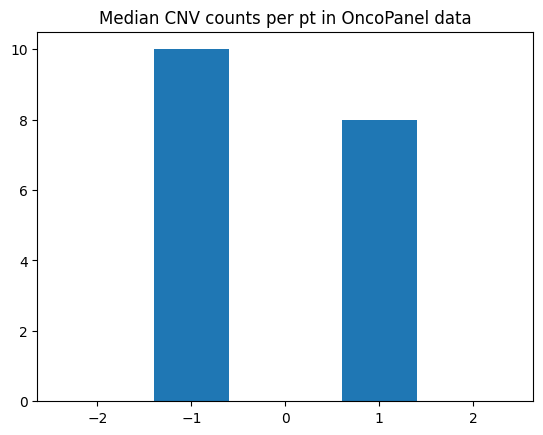

In [88]:
plot_variant_median_rates(op_cnv_df, pt_col="participant_id_legacy", variant_col="hlvl_call")
plt.title("Median CNV counts per pt in OncoPanel data")
plt.show()

# Prepare the ICB WES data

Get the participants who have pre-ICB WES tumor data but NOT OncoPanel call

In [89]:
pre_sample_df = icb_sample_df[(icb_sample_df["pre_post"] ==  "Pre") & (icb_sample_df["tumor_normal"] == "tumor")]
pt_usable_data = pre_sample_df[["participant_id_legacy", "usable_wes", "usable_oncopanel"]].groupby("participant_id_legacy").any()
pt_usable_data = pt_usable_data[pt_usable_data["usable_wes"] & (~pt_usable_data["usable_oncopanel"])]

wes_pt_df = icb_pt_df[icb_pt_df["participant_id_legacy"].isin(pt_usable_data.index)]

### Load and process ICB WES sequence variants

In [90]:
wes_mut_df = pd.read_pickle('../../../results/2023-10-11_process_mafs/all_mut_ccfs_maf.pickle')

Filter WES sequence variants by various criteria:

In [91]:
# Keep only variants for pts without OncoPanel data
wes_mut_df = wes_mut_df[wes_mut_df["Patient_ID"].isin(wes_pt_df["participant_id_legacy"])]

# Correct some sample IDs that erroneously end with "_pair"
wes_mut_df["Sample_ID"] = wes_mut_df["Sample_ID"].map(lambda x: x[:-5] if x.endswith("_pair") else x)

# Filter by CCF
cluster_ccf_threshold = 0.1
wes_mut_df = wes_mut_df[wes_mut_df["clust_ccf_mean"] > cluster_ccf_threshold]

# Restrict to genes covered by OncoPanel
wes_mut_df = wes_mut_df[wes_mut_df["Hugo_Symbol"].isin(oncopanel_genes["Gene"])]

# Remove silent and non-coding mutations. 
# This is consistent with the filtering of GLASS variants
wes_mut_df = wes_mut_df[~wes_mut_df["variant_type"].isin(["silent", "non_coding"])]

# Keep only variants belonging to their latest pre-ICB timepoint.
wes_mut_df = keep_latest_preicb_timepoint_variants(wes_mut_df, pre_sample_df, sample_id_col="Sample_ID")

In [92]:
wes_mut_df["variant_type"].value_counts()

variant_type
neoantigen    26
nonsense       4
Name: count, dtype: int64

In [93]:
wes_mut_df["gene_mut"] = wes_mut_df["Hugo_Symbol"]+"_mut"

In [94]:
wes_mut_matrix = wes_mut_df.pivot_table(index = 'participant_id_legacy', columns = 'gene_mut', aggfunc = 'size', fill_value = 0)

# In this methodology, sequence variants are given weight = 2
wes_mut_matrix *= 2.0

In [95]:
wes_mut_matrix

gene_mut,BRD4_mut,EGFR_mut,ERCC2_mut,FLT3_mut,GNAS_mut,KDR_mut,MITF_mut,MSH6_mut,NOTCH1_mut,PDGFRA_mut,PIK3CA_mut,PTEN_mut,RB1_mut,TET2_mut,TP53_mut,TSC1_mut,WT1_mut
participant_id_legacy,,,,,,,,,,,,,,,,,
GBM.ICB-139,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
GBM.ICB-212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-253,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-28,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-30,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-37,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0
GBM.ICB-42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0


### Load and process ICB WES CNVs

In [106]:
wes_cnv_df = pd.concat([
    pd.read_csv('../data/icb_wes_tnpair_gene_allelic_cn.maf', sep = '\t'),
    pd.read_csv('../data/icb_wes_tonly_gene_allelic_cn.maf', sep = '\t')
])

In [98]:
# Some helper functions
def call_hlvl(cn_col, thresholds=[0.8, 1.8, 2.2, 3.2], values=[-2,-1,0,1,2]): 
    dig = np.digitize(cn_col.values, thresholds)
    hlvl = np.array(values)[dig]
    return pd.Series(data=hlvl, index=cn_col.index)

Filter the variants by various criteria

In [99]:
# Keep only variants belonging to the latest pre-ICB timepoint for each pt
wes_cnv_df = keep_latest_preicb_timepoint_variants(wes_cnv_df, icb_sample_df, sample_id_col="sample")

# Restrict to ICB pts that only have WES data (and not OncoPanel)
wes_cnv_df = wes_cnv_df[wes_cnv_df["participant_id_legacy"].isin(wes_pt_df["participant_id_legacy"])]

# Restrict to genes covered by OncoPanel
wes_cnv_df = wes_cnv_df[wes_cnv_df["gene"].isin(oncopanel_genes["Gene"])]

Annotate gene-level copy number gains, losses, etc.

In [100]:
wes_cnv_df["hlvl_call"] = call_hlvl(wes_cnv_df["corrected_total_cn"])

# Use ABSOLUTE's homozygous deletions
wes_cnv_df.loc[wes_cnv_df["HZ"] == 1, "hlvl_call"] = -2

# Finally: keep only the actual CNVs
wes_cnv_df = wes_cnv_df.loc[wes_cnv_df["hlvl_call"] != 0,:]

In [101]:
wes_cnv_df["gene_cnv"] = wes_cnv_df["gene"] + "_cnv"

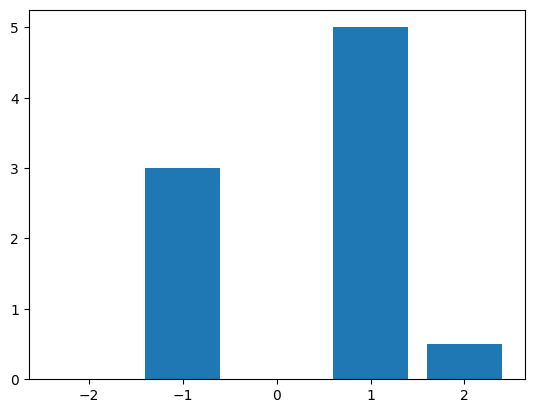

In [102]:
plot_variant_median_rates(wes_cnv_df, pt_col="participant_id_legacy")

In [103]:
wes_cnv_matrix = wes_cnv_df.pivot_table(index = 'participant_id_legacy', columns = 'gene_cnv', aggfunc = 'sum', values = "hlvl_call", fill_value = 0)

In [104]:
wes_cnv_matrix

gene_cnv,AKT1_cnv,AKT3_cnv,ARID2_cnv,BAP1_cnv,BUB1B_cnv,CARD11_cnv,CCND1_cnv,CCND2_cnv,CCNE1_cnv,CDK4_cnv,...,PTEN_cnv,RAD21_cnv,RARA_cnv,RB1_cnv,RET_cnv,SETD2_cnv,SMARCB1_cnv,SOX2_cnv,TNFAIP3_cnv,TP53_cnv
participant_id_legacy,,,,,,,,,,,,,,,,,,,,,
GBM.ICB-139,-1,0,0,0,-1,3,0,0,3,0,...,-3,0,0,0,-3,0,0,0,0,0
GBM.ICB-144,0,1,0,1,0,1,0,2,1,2,...,0,1,1,0,1,1,0,1,1,0
GBM.ICB-212,-1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
GBM.ICB-253,2,1,2,1,2,4,1,2,2,2,...,0,2,0,2,0,1,2,2,1,2
GBM.ICB-28,0,0,0,0,0,1,0,0,0,0,...,-1,0,0,0,0,0,2,0,0,0
GBM.ICB-30,0,1,0,0,-1,1,0,0,1,0,...,-1,1,0,0,-1,0,0,0,0,0
GBM.ICB-32,0,0,0,0,0,0,-2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GBM.ICB-37,2,2,1,1,0,2,1,1,1,1,...,0,0,1,0,0,1,0,1,2,0
GBM.ICB-42,0,0,0,0,-1,1,0,0,0,0,...,-1,0,0,-1,-1,0,0,0,0,0


# Combine all filtered variants for ICB cohort

In [105]:
op_matrix = op_variants_matrix.join(op_cnvs_matrix, how = 'outer').fillna(0)
print(op_matrix.shape)

(154, 356)


In [106]:
icb_wes_matrix = wes_mut_matrix.join(wes_cnv_matrix, how="outer").fillna(0)

In [107]:
icb_matrix = pd.concat((op_matrix, icb_wes_matrix)).fillna(0)

Keep only alteration types significantly associated with clusters in GLASS

In [108]:
glass_alterations = list(matrix_sig)
missing = set(glass_alterations) - set(icb_matrix)
len(missing)

54

In [109]:
for c in missing:
    icb_matrix[c] = 0.0

icb_matrix = icb_matrix[list(matrix_sig)]

print(icb_matrix.shape, matrix_sig.shape)

(166, 373) (365, 373)


/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_5044/3716084494.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  icb_matrix[c] = 0.0
/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_5044/3716084494.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  icb_matrix[c] = 0.0
/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_5044/3716084494.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

In [110]:
icb_matrix.index.nunique()

166

In [111]:
icb_sample_df[(icb_sample_df["pre_post"] == "Pre") & (icb_sample_df["tumor_normal"] == "tumor") & (icb_sample_df["usable_oncopanel"] | icb_sample_df["usable_wes"])]["participant_id_legacy"].nunique()

167

# Classify the ICB participants

## Apply the best classifier

In [112]:
#best_model.fit(X, y)

In [113]:
cluster_labels = [f"cluster_{c}" for c in best_model.classes_]

icb_pred = best_model.predict_proba(icb_matrix)
icb_pred_df = pd.DataFrame(data=icb_pred, index = icb_matrix.index, columns=cluster_labels)
icb_pred_df["cluster"] = icb_pred_df.apply(lambda row: cluster_labels[np.argmax(row)], axis=1)

icb_pred_df['cluster'].value_counts()

cluster
cluster_3    92
cluster_2    50
cluster_4    12
cluster_6     6
cluster_1     6
Name: count, dtype: int64

In [114]:
icb_results = icb_pred_df

icb_results = icb_results.merge(icb_pt_df, left_on='participant_id_legacy', right_on="participant_id_legacy")

icb_results = icb_results[icb_results['MGMT methylated Y/N'].notnull()]

icb_results['setting'] = icb_results['ICB for Newly diagnosed']
icb_results['vital_status'] = icb_results['Deceased'].map({'Deceased': 1, 'Alive': 0})
icb_results['mgmt_methylated'] = icb_results['MGMT methylated Y/N'].replace({'Unmethylated': 0.0, 'Methylated': 1.0, 'Partially': 1.0})

print(icb_results['participant_id'].nunique()) #, icb_results['sample_id_legacy'].nunique())

156


/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_5044/2732675569.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  icb_results['mgmt_methylated'] = icb_results['MGMT methylated Y/N'].replace({'Unmethylated': 0.0, 'Methylated': 1.0, 'Partially': 1.0})


## Output predicted cluster assignments to TSV

In [115]:
icb_pt_df = icb_pt_df.merge(icb_pred_df, left_on="participant_id_legacy", right_index=True)

In [116]:
icb_pt_df.to_csv("../results/icb_pt_w_cluster_assignments.tsv", sep="\t")

## Assess prognostic value

In [117]:
%%R -i icb_results
library(tidyverse)
library(survival)

combined <- icb_results %>%
    mutate(cluster = as.factor(cluster))
nd <- combined %>% filter(str_equal(setting, 'Newly-diagnosed'))
rc <- combined %>% filter(str_equal(setting, 'Recurrent'))

print(dim(combined))
print(dim(nd))
print(dim(rc))

model_6_combined <- coxph(Surv(osicb, vital_status) ~ setting + mgmt_methylated + cluster,
                          data = combined)
model_6_nd <- coxph(Surv(osicb, vital_status) ~ mgmt_methylated + cluster,
                          data = nd)
model_6_rc <- coxph(Surv(osicb, vital_status) ~ mgmt_methylated + cluster,
                          data = rc)

print(summary(model_6_combined))
print(summary(model_6_nd))
print(summary(model_6_rc))

[1] 156  58
[1] 37 58
[1] 119  58
Call:
coxph(formula = Surv(osicb, vital_status) ~ setting + mgmt_methylated + 
    cluster, data = combined)

  n= 156, number of events= 144 

                    coef exp(coef) se(coef)      z Pr(>|z|)   
settingRecurrent  0.6657    1.9458   0.2047  3.252  0.00115 **
mgmt_methylated  -0.3323    0.7172   0.1798 -1.849  0.06447 . 
clustercluster_2  0.9998    2.7178   0.5366  1.863  0.06244 . 
clustercluster_3  1.0022    2.7243   0.5217  1.921  0.05472 . 
clustercluster_4  0.8127    2.2541   0.5982  1.359  0.17427   
clustercluster_6  0.3399    1.4047   0.6772  0.502  0.61577   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                 exp(coef) exp(-coef) lower .95 upper .95
settingRecurrent    1.9458     0.5139    1.3028     2.906
mgmt_methylated     0.7172     1.3942    0.5043     1.020
clustercluster_2    2.7178     0.3679    0.9494     7.780
clustercluster_3    2.7243     0.3671    0.9799     7.574
clustercluster_4    2.2

/Users/merrell/miniconda3/envs/dalmatian/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "AE". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


## Create a heatmap of ICB cohort, grouped by predicted cluster

In [118]:
icb_matrix

,MTOR_mut,MTOR_cnv,SDHB_cnv,ID3_cnv,ARID1A_mut,ARID1A_cnv,MYCL_mut,MYCL_cnv,MPL_cnv,MUTYH_cnv,...,AR_mut,AR_cnv,ATRX_mut,ATRX_cnv,STAG2_cnv,BCORL1_mut,BCORL1_cnv,GPC3_mut,GPC3_cnv,PHF6_cnv
participant_id_legacy,,,,,,,,,,,,,,,,,,,,,
GBM.ICB-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GBM.ICB-37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBM.ICB-43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
icb_pred_df["k = 6"] = icb_pred_df["cluster"].map(lambda x: x.split("_")[-1])

In [120]:
icb_matrix = icb_matrix.join(icb_pred_df)

In [121]:
icb_matrix

,MTOR_mut,MTOR_cnv,SDHB_cnv,ID3_cnv,ARID1A_mut,ARID1A_cnv,MYCL_mut,MYCL_cnv,MPL_cnv,MUTYH_cnv,...,GPC3_cnv,PHF6_cnv,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster,k = 6
participant_id_legacy,,,,,,,,,,,,,,,,,,,,,
GBM.ICB-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.074491e-118,1.264753e-189,3.715958e-72,1.000000e+00,9.015244e-90,9.048269e-168,cluster_4,4
GBM.ICB-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,2.456832e-62,1.000000e+00,1.074327e-131,5.435159e-226,5.788198e-50,cluster_3,3
GBM.ICB-102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,5.000000e-01,5.000000e-01,2.283606e-98,1.400666e-83,5.526794e-126,cluster_2,2
GBM.ICB-103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.360496e-237,9.397800e-140,4.574012e-79,cluster_3,3
GBM.ICB-104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.267862e-82,3.320733e-186,4.783794e-14,2.679068e-87,1.404272e-96,1.000000e+00,cluster_6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GBM.ICB-37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.757771e-276,1.545544e-77,0.000000e+00,5.385083e-255,0.000000e+00,1.000000e+00,cluster_6,6
GBM.ICB-42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.606283e-194,2.480102e-284,1.000000e+00,7.371171e-267,3.594879e-141,9.024257e-239,cluster_3,3
GBM.ICB-43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.729017e-183,0.000000e+00,6.245601e-47,1.000000e+00,2.965613e-240,6.162254e-163,cluster_4,4


In [122]:
%%R -i icb_matrix -i cnv_chrom_df -w 3000 -h 1200
library(ComplexHeatmap)
library(circlize)
library(RColorBrewer)

icb_matrix <- icb_matrix[order(icb_matrix$`k = 6`),]

muts <- as.matrix(icb_matrix[, grep('_mut', names(icb_matrix))])
cnvs <- as.matrix(icb_matrix[, grep('_cnv', names(icb_matrix))])

clusters <- icb_matrix[, grep('=', names(icb_matrix))]
cluster_colors <- brewer.pal(n = 8, name = 'Dark2')

chrom_colors <- rep(c(cluster_colors[6], cluster_colors[8]), length.out = 23)
chrom_colors <- setNames(chrom_colors, 1:23)

row_ha <- rowAnnotation(#Cluster_2 = clusters$`k = 2`,
                        #Cluster_3 = clusters$`k = 3`,
                        #Cluster_4 = clusters$`k = 4`,
                        #Cluster_5 = clusters, #clusters$`k = 5`,
                        Cluster_6 = clusters, #clusters$`k = 5`,
                        col = list(#Cluster_2 = c(`1` = cluster_colors[1], `2` = cluster_colors[2]),
                                   #Cluster_3 = c(`1` = cluster_colors[1], `2` = cluster_colors[2], `3` = cluster_colors[3]),
                                   #Cluster_4 = c(`1` = cluster_colors[1], `2` = cluster_colors[2], `3` = cluster_colors[3], `4` = cluster_colors[4]),
                                   #Cluster_5 = c(`1` = cluster_colors[1], `2` = cluster_colors[2], `3` = cluster_colors[3], `4` = cluster_colors[4], `5` = cluster_colors[5])),
                                   Cluster_6 = c(`1` = cluster_colors[1], `2` = cluster_colors[2], `3` = cluster_colors[3], `4` = cluster_colors[4], `5` = cluster_colors[5], `6` = cluster_colors[6])),
                        simple_anno_size = unit(2, 'cm'))

col_ha <- columnAnnotation(df = cnv_chrom_df,
                          simple_anno_size = unit(2, 'cm'),
                          col = list(chrom = chrom_colors))

heatmap_muts <- Heatmap(muts, name = 'SNV/indels',
                        col = colorRamp2(c(0, 2, 4), c('white', 'grey', 'black')),
                        cluster_rows = FALSE, cluster_columns = FALSE,
                        show_row_names = FALSE)

heatmap_cnvs <- Heatmap(cnvs, name = 'CNVs', right_annotation = row_ha, top_annotation = col_ha,
                        col = colorRamp2(c(-2, 0, 2), c('blue', 'white', 'red')),
                        cluster_rows = FALSE, cluster_columns = FALSE,
                        show_row_names = FALSE)

full_heatmap <- heatmap_muts + heatmap_cnvs
pdf("icb_heatmap.pdf", width=50, height=10)
draw(full_heatmap)
dev.off()

quartz_off_screen 
                2 
